###Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date,timedelta

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Case Studies/JP Morgan&Chase/Task 1/Nat_Gas.csv',parse_dates=['Dates'])
df

<ipython-input-2-1548454911>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/drive/MyDrive/Case Studies/JP Morgan&Chase/Task 1/Nat_Gas.csv',parse_dates=['Dates'])


,Dates,Prices
0,2020-10-31,10.10
1,2020-11-30,10.30
2,2020-12-31,11.00
3,2021-01-31,10.90
4,2021-02-28,10.90
5,2021-03-31,10.90
6,2021-04-30,10.40
7,2021-05-31,9.84
8,2021-06-30,10.00
9,2021-07-31,10.10


In [ ]:
prices = df['Prices'].values

In [ ]:
dates = df['Dates'].values

###EDA

<ipython-input-5-1346016323>:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(dates,prices,'-')


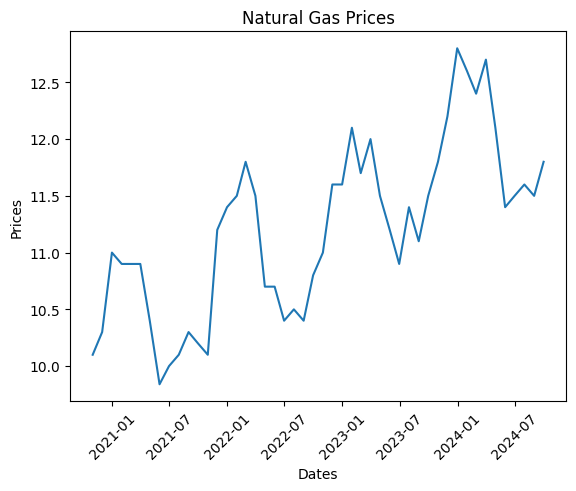

In [ ]:
fig,ax = plt.subplots()
ax.plot_date(dates,prices,'-')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x',rotation=45)
plt.show()

From the plot:
* See the prices have a natural frequency of around a year
* The overall trend is upwards
* Trend can be captured using Linear regression
* Variation in each year can be modeled using sin function.

###Data conversion

In [ ]:
#Convert the date in terms of days from the start
#makes it easier to interpolate later.

start_date = date(2020,10,31)
end_date = date(2024,9,30)
months=[]
year = start_date.year
month = start_date.month + 1

while True:
  current = date(year,month,1) + timedelta(days=-1)
  months.append(current)
  if current.month == end_date.month and current.year == end_date.year:
    break
  else:
    month = ((month+1) % 12) or 12
    if month == 1:
      year += 1

days_from_start = [(day - start_date).days for day in months]

model:
$$y = Ax + b$$

Estimator of then slope:
$$\hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$$

Intercept of the slope:
$$\hat{B} = \bar{y} - \hat{A}*\bar{x}$$



###Model Building

In [ ]:
#Build the regression model
def simple_regression(x,y):
  x_bar = np.mean(x)
  y_bar = np.mean(y)
  slope = np.sum((x-x_bar)*(y-y_bar))/np.sum((x-x_bar)**2)
  intercept = y_bar - slope*x_bar
  return slope,intercept

time = np.array(days_from_start)
slope,intercept = simple_regression(time,prices)

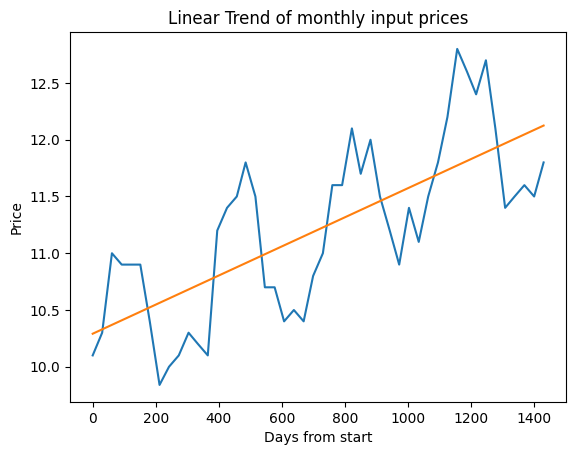

0.001282373598760221 10.29104112595228


In [ ]:
#Plot the linear trend
plt.plot(time,prices)
plt.plot(time,time*slope+intercept)
plt.xlabel('Days from start')
plt.ylabel('Price')
plt.title('Linear Trend of monthly input prices')
plt.show()
print(slope,intercept)

From the above plot, it is visible that Linear trend has been captured.

Given, natural gas is used **more in winter** and **less in summer** → we can guess the frequency of prices to be about a year/12 months

Thus, we have a **model** with known frequency:
$$y = Asin( kt + z )$$
Rewriting it as:
$$y = Acos(z)sin(kt) + Acos(kt)sin(z)$$

To solve for $u = Acos(z)$ and $w = Asin(z)$ we can use bilinear regression with no intercept

In [ ]:
sin_prices = prices - (slope*time + intercept)
sin_time = np.sin(time*2*np.pi / (365))
cos_time = np.cos(time*2*np.pi / (365))

In [ ]:
#Bilinear regression without intercept leads to projection onto the x-vectors

def bilinear_regression(y,x1,x2):
  slope1 = np.sum(y*x1)/np.sum(x1**2)
  slope2 = np.sum(y*x2)/np.sum(x2**2)
  return (slope1,slope2)

slope1,slope2 = bilinear_regression(sin_prices,sin_time,cos_time)

Amplitude:
$$A = slope1^2 + slope2^2$$
phase shift:
$$z = \tan^{-1}(slope2/slope1)$$

In [ ]:
#We now recover the original amplitude and phase shift as
amplitude = np.sqrt(slope1**2 + slope2**2)
shift = np.arctan2(slope2,slope)

Text(0.5, 1.0, 'Smoothed estimate of full dataset')

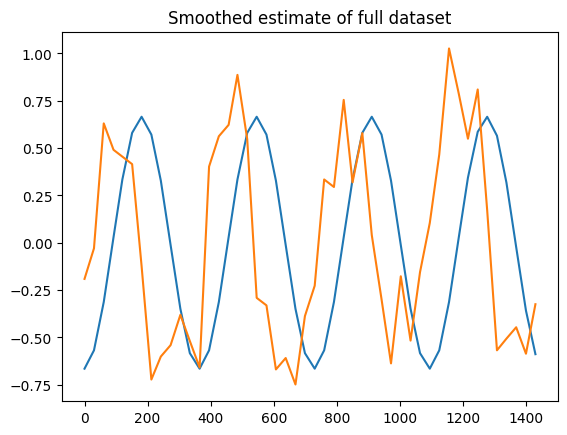

In [ ]:
#Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time*2*np.pi / 365 + shift))
plt.plot(time,sin_prices)
plt.title('Smoothed estimate of full dataset')

In [ ]:
#Define the interpolation/extrapolation function
def interpolate(date):
  days = (date - pd.Timestamp(start_date)).days
  if days in days_from_start:
    return prices[days_from_start.index(days)]
  else:
    return amplitude * np.sin(days*2*np.pi / 365 + shift) + days*slope + intercept

In [ ]:
#Creating a range of continuous dates from start_date to end_date
continuous_dates = pd.date_range(start = pd.Timestamp(start_date),end = pd.Timestamp(end_date),freq='D')

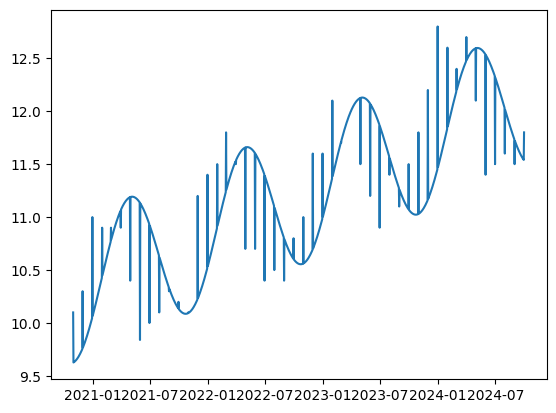

In [ ]:
#Plotting smoothe estimate of full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates],label='Smoothed estiimate')

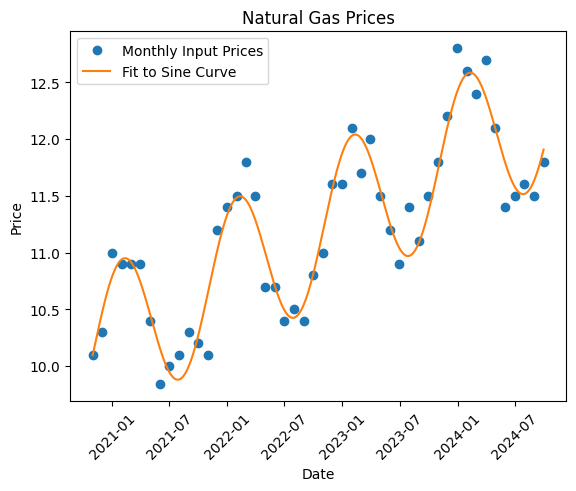

In [ ]:
#Fitting the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)

fit_amplitude = np.sqrt(slope1**2 + slope2**2)
fit_shift = np.arctan2(slope2,slope1)

fit_slope, fit_intercept = simple_regression(x,y - fit_amplitude *
                                             np.sin(x*2*np.pi / 365 + fit_shift))

plt.plot(dates,y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift)
+ (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.xticks(rotation=45)
plt.legend()
plt.show()